# **Άσκηση στους Autoencoders**

Στα πλαίσια της άσκησης θα εξετάσετε πως δουλεύει ένας αυτόματος κωδικοποιητής (autoencoder) για την ταξινόμηση ενός συνόλου δεδομένων.



In [2]:
# train autoencoder for classification with no compression in the bottleneck layer
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.utils.vis_utils import plot_model
from matplotlib import pyplot

Θα χρησιμοποιήσουμε τη συνάρτηση make_classification() scikit-learn για να ορίσουμε ένα συνθετικό σύνολο δεδομένων ταξινόμησης (2 κλάσεων) με 100 χαρακτηριστικά εισόδου (στήλες) και 1.000 παραδείγματα (γραμμές). 

**Προσοχή**: *Στο δοθέν πρόβλημα τα περισσότερα από τα χαρακτηριστικά είναι περιττά κατά 90%, επιτρέποντας στον autoencoder αργότερα να μάθει μια πραγματικά χρήσιμη συμπιεσμένη αναπαράσταση.*


In [3]:
# synthetic classification dataset
from sklearn.datasets import make_classification
# define dataset
X, y = make_classification(n_samples=1000, n_features=100, n_informative=10, n_redundant=90, random_state=1)
# number of input columns
n_inputs = X.shape[1]
# summarize the dataset
print(X.shape, y.shape)

(1000, 100) (1000,)


Στη συνέχεια, θα αναπτύξουμε ένα μοντέλο αυτόματου κωδικοποιητή [Multilayer Perceptron (MLP)](https://en.wikipedia.org/wiki/Multilayer_perceptron).

Το μοντέλο θα λάβει όλα τα παραδείγματα στην είσοδο και μετά θα εξάγει τις ίδιες τιμές.Συνεπώς θα μάθει να αναδημιουργεί το ίδιο μοτίβο

Ο αυτόματος κωδικοποιητής αποτελείται από δύο μέρη τον κωδικοποιητή και τον αποκωδικοποιητή.

Μόλις εκπαιδευτεί ο autoencoder, ο αποκωδικοποιητής δεν θα χρησιμοποιηθεί ξανά και κρατάμε μόνο τον κωδικοποιητή για να συμπιέσουμε παραδείγματα εισόδου στα διανύσματα που εξάγονται από το bottleneck.

Σε αυτόν τον πρώτο αυτόματο κωδικοποιητή, δεν θα συμπιέσουμε καθόλου την είσοδο και θα χρησιμοποιήσουμε ενδιάμεσες συνάψεις ίδιου αριθμού με τον αριθμό των κόμβων εισόδου (άρα ίσο με τον αριθμό των διαστάσεων του δείγματος). Αυτό θα εφαρμοστεί ώστε το μοντέλο να μάθει σχεδόν τέλεια και να επιβεβαιώσουμε ότι το μοντέλο έχει εφαρμοστεί σωστά.

Πριν ορίσουμε και προσαρμόσουμε το μοντέλο, θα χωρίσουμε τα δεδομένα σε σύνολα εκπαίδευσης και δοκιμής και θα κλιμακώσουμε τα δεδομένα εισόδου κανονικοποιώντας τις τιμές στο εύρος 0-1.

In [4]:
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

Θα ορίσουμε ότι ο κωδικοποιητής θα έχει δύο κρυφά επίπεδα, το πρώτο με διπλάσιο αριθμό διαστάσεων εισόδου (π.χ. 200) και το δεύτερο με τον αρχικό αριθμό διαστάσεων (100).


In [5]:
# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)

Στη συνέχεια ορίζουμε τον αποκωδικοποιητή. Ο αποκωδικοποιητής θα έχει την αντίστροφη δομή από τον κωδικοποιητή.

In [6]:
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)

Στη συνέχεια κάνουμε compile το μοντέλο μας. Για να εντοπίσουμε την διαφορά μεταξύ του trained και του test, χρησιμοποιούμε την μέθοδο των ελάχιστων τετραγώνων.

In [7]:
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

Στη συνέχεια, μπορούμε να εκπαιδεύσουμε το μοντέλο να αναπαράγει τα δεδομένα εισόδου και να παρακολουθεί την απόδοση του μοντέλου σε σύγκριση με το test set.

**Ερώτηση 1**: Ποια είναι η διαφορά μεταξύ mini-batch και epochs


Το mini-batch αναφέρεται σε ίσου μεγέθους υποσύνολα του dataset πάνω στα οποία υπολογίζεται το gradient και ανανεώνονται τα βάρη. Συνδυάζει ουσιαστικά το batch με το stochastic training μέσω της επιλογής από το χρήστη ενός αριθμού training items, αντί για χρήση ενός training item ή όλων των training items.

Ο αριθμός εποχών είναι ο αριθμός ολοκληρωμένων περασμάτων όλων των δειγματικών στοιχείων εκπαίδευσης από το δίκτυο για την εκπαίδευσή του.

In [8]:
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=2, validation_data=(X_test,X_test))

Epoch 1/200
42/42 - 5s - loss: 0.2252 - val_loss: 0.1678 - 5s/epoch - 109ms/step
Epoch 2/200
42/42 - 0s - loss: 0.0356 - val_loss: 0.1046 - 258ms/epoch - 6ms/step
Epoch 3/200
42/42 - 0s - loss: 0.0224 - val_loss: 0.0498 - 284ms/epoch - 7ms/step
Epoch 4/200
42/42 - 0s - loss: 0.0177 - val_loss: 0.0290 - 249ms/epoch - 6ms/step
Epoch 5/200
42/42 - 0s - loss: 0.0148 - val_loss: 0.0191 - 299ms/epoch - 7ms/step
Epoch 6/200
42/42 - 0s - loss: 0.0141 - val_loss: 0.0163 - 255ms/epoch - 6ms/step
Epoch 7/200
42/42 - 0s - loss: 0.0143 - val_loss: 0.0103 - 260ms/epoch - 6ms/step
Epoch 8/200
42/42 - 0s - loss: 0.0117 - val_loss: 0.0097 - 258ms/epoch - 6ms/step
Epoch 9/200
42/42 - 0s - loss: 0.0104 - val_loss: 0.0070 - 241ms/epoch - 6ms/step
Epoch 10/200
42/42 - 0s - loss: 0.0106 - val_loss: 0.0062 - 274ms/epoch - 7ms/step
Epoch 11/200
42/42 - 0s - loss: 0.0091 - val_loss: 0.0054 - 244ms/epoch - 6ms/step
Epoch 12/200
42/42 - 0s - loss: 0.0096 - val_loss: 0.0056 - 258ms/epoch - 6ms/step
Epoch 13/200
4

Παρακάτω παρατείθενται οι καμπύλες μάθησης για το train και το test dataset.

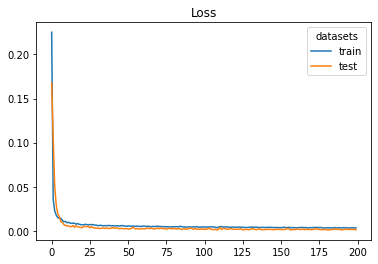

In [9]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend(title = "datasets")
pyplot.title("Loss")
pyplot.show()

**Ερώτηση 2**: Δοκιμάστε να τρέξετε το μοντέλο με Bottleneck: α) 50 και β) 25. Τι παρατηρείτε ως προς τα αποτελέσματα του μοντέλου;
**Ερώτηση 3**: δοκιμάστε να βάλετε τρία επίπεδα (τα δύο υφιστάμενα και ένα ακόμα με bottleneck 50). Τι διαφορές παρατηρείτε;

## Bottleneck = 50

Epoch 1/200
42/42 - 4s - loss: 0.2196 - val_loss: 0.1808 - 4s/epoch - 101ms/step
Epoch 2/200
42/42 - 0s - loss: 0.0392 - val_loss: 0.0992 - 259ms/epoch - 6ms/step
Epoch 3/200
42/42 - 0s - loss: 0.0263 - val_loss: 0.0518 - 232ms/epoch - 6ms/step
Epoch 4/200
42/42 - 0s - loss: 0.0199 - val_loss: 0.0299 - 262ms/epoch - 6ms/step
Epoch 5/200
42/42 - 0s - loss: 0.0174 - val_loss: 0.0193 - 290ms/epoch - 7ms/step
Epoch 6/200
42/42 - 0s - loss: 0.0157 - val_loss: 0.0137 - 200ms/epoch - 5ms/step
Epoch 7/200
42/42 - 0s - loss: 0.0149 - val_loss: 0.0117 - 217ms/epoch - 5ms/step
Epoch 8/200
42/42 - 0s - loss: 0.0131 - val_loss: 0.0096 - 316ms/epoch - 8ms/step
Epoch 9/200
42/42 - 0s - loss: 0.0116 - val_loss: 0.0085 - 267ms/epoch - 6ms/step
Epoch 10/200
42/42 - 0s - loss: 0.0115 - val_loss: 0.0065 - 235ms/epoch - 6ms/step
Epoch 11/200
42/42 - 0s - loss: 0.0100 - val_loss: 0.0062 - 216ms/epoch - 5ms/step
Epoch 12/200
42/42 - 0s - loss: 0.0097 - val_loss: 0.0059 - 313ms/epoch - 7ms/step
Epoch 13/200
4

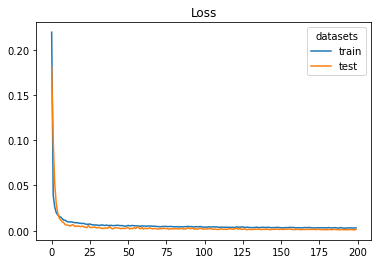

In [10]:
# define encoder
visible = Input(shape=(n_inputs,))

# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = 50
bottleneck = Dense(n_bottleneck)(e)


# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)

# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=2, validation_data=(X_test,X_test))

# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend(title = "datasets")
pyplot.title("Loss")
pyplot.show()

Παρατηρούμε ότι το validation loss για Bottleneck = 50 δε διαφέρει σημαντικά από προηγουμένως όπου είχαμε Bottleneck = Number of inputs = 100. Ωστόσο γενικώς αναμένουμε με μείωση της τιμής του bottleneck να έχουμε αύξηση του validation error, καθώς με τον τρόπο αυτό επιτυγχάνεται αυξημέη συμπίεση του dataset. Αυτό σημαίνει χειρότερη ανάκτηση των αρχικών δεδομένων μετά το decoding.

## Bottleneck = 25

Epoch 1/200
42/42 - 4s - loss: 0.2197 - val_loss: 0.1931 - 4s/epoch - 90ms/step
Epoch 2/200
42/42 - 0s - loss: 0.0312 - val_loss: 0.1069 - 201ms/epoch - 5ms/step
Epoch 3/200
42/42 - 0s - loss: 0.0207 - val_loss: 0.0545 - 216ms/epoch - 5ms/step
Epoch 4/200
42/42 - 0s - loss: 0.0178 - val_loss: 0.0313 - 235ms/epoch - 6ms/step
Epoch 5/200
42/42 - 0s - loss: 0.0156 - val_loss: 0.0199 - 209ms/epoch - 5ms/step
Epoch 6/200
42/42 - 0s - loss: 0.0135 - val_loss: 0.0129 - 199ms/epoch - 5ms/step
Epoch 7/200
42/42 - 0s - loss: 0.0137 - val_loss: 0.0097 - 200ms/epoch - 5ms/step
Epoch 8/200
42/42 - 0s - loss: 0.0115 - val_loss: 0.0085 - 214ms/epoch - 5ms/step
Epoch 9/200
42/42 - 0s - loss: 0.0115 - val_loss: 0.0076 - 191ms/epoch - 5ms/step
Epoch 10/200
42/42 - 0s - loss: 0.0105 - val_loss: 0.0066 - 192ms/epoch - 5ms/step
Epoch 11/200
42/42 - 0s - loss: 0.0112 - val_loss: 0.0057 - 192ms/epoch - 5ms/step
Epoch 12/200
42/42 - 0s - loss: 0.0097 - val_loss: 0.0054 - 192ms/epoch - 5ms/step
Epoch 13/200
42

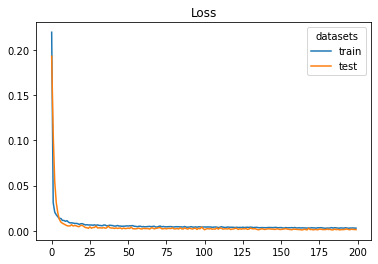

In [11]:
# define encoder
visible = Input(shape=(n_inputs,))

# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = 25
bottleneck = Dense(n_bottleneck)(e)


# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)

# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=2, validation_data=(X_test,X_test))

# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend(title = "datasets")
pyplot.title("Loss")
pyplot.show()

Μειώνοντας περαιτέρω το bottleneck από 50 σε 25, πάλι δεν παρατηρούμε κάποια σημαντική διαφορά στις τιμές του validation error στο τέλος των επιλεγμένων εποχών όπως και στη μορφή της γραφικής παράστασης που δείχνει τα σφάλματα.

## Bottleneck = 3

Epoch 1/200
42/42 - 3s - loss: 0.1664 - val_loss: 0.1890 - 3s/epoch - 67ms/step
Epoch 2/200
42/42 - 0s - loss: 0.0308 - val_loss: 0.1038 - 294ms/epoch - 7ms/step
Epoch 3/200
42/42 - 0s - loss: 0.0239 - val_loss: 0.0566 - 221ms/epoch - 5ms/step
Epoch 4/200
42/42 - 0s - loss: 0.0224 - val_loss: 0.0371 - 220ms/epoch - 5ms/step
Epoch 5/200
42/42 - 0s - loss: 0.0201 - val_loss: 0.0235 - 238ms/epoch - 6ms/step
Epoch 6/200
42/42 - 0s - loss: 0.0196 - val_loss: 0.0204 - 213ms/epoch - 5ms/step
Epoch 7/200
42/42 - 0s - loss: 0.0191 - val_loss: 0.0176 - 222ms/epoch - 5ms/step
Epoch 8/200
42/42 - 0s - loss: 0.0181 - val_loss: 0.0149 - 255ms/epoch - 6ms/step
Epoch 9/200
42/42 - 0s - loss: 0.0168 - val_loss: 0.0151 - 191ms/epoch - 5ms/step
Epoch 10/200
42/42 - 0s - loss: 0.0168 - val_loss: 0.0142 - 201ms/epoch - 5ms/step
Epoch 11/200
42/42 - 0s - loss: 0.0170 - val_loss: 0.0145 - 208ms/epoch - 5ms/step
Epoch 12/200
42/42 - 0s - loss: 0.0171 - val_loss: 0.0144 - 254ms/epoch - 6ms/step
Epoch 13/200
42

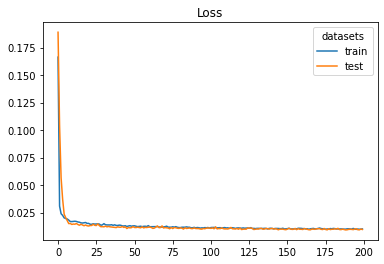

In [14]:
# define encoder
visible = Input(shape=(n_inputs,))

# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = 3
bottleneck = Dense(n_bottleneck)(e)


# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)

# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=2, validation_data=(X_test,X_test))

# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend(title = "datasets")
pyplot.title("Loss")
pyplot.show()

Τέλος, παίρνοντας πολύ μικρή τιμή για το bottleneck (3), καταδεικνύουμε την ισχύ των προηγούμενων προτάσεων, καθώς το validation loss έπειτα από 200 εποχές είναι σχεδόν μια τάξη μεγέθους μεγαλύτερο από το validation loss στις προηγούμενες περιπτώσεις.

## 3 layers and bottleneck = 50

Epoch 1/200
42/42 - 3s - loss: 0.2505 - val_loss: 0.1695 - 3s/epoch - 77ms/step
Epoch 2/200
42/42 - 0s - loss: 0.0397 - val_loss: 0.1167 - 174ms/epoch - 4ms/step
Epoch 3/200
42/42 - 0s - loss: 0.0248 - val_loss: 0.0666 - 197ms/epoch - 5ms/step
Epoch 4/200
42/42 - 0s - loss: 0.0197 - val_loss: 0.0386 - 202ms/epoch - 5ms/step
Epoch 5/200
42/42 - 0s - loss: 0.0175 - val_loss: 0.0229 - 210ms/epoch - 5ms/step
Epoch 6/200
42/42 - 0s - loss: 0.0151 - val_loss: 0.0149 - 300ms/epoch - 7ms/step
Epoch 7/200
42/42 - 0s - loss: 0.0141 - val_loss: 0.0131 - 204ms/epoch - 5ms/step
Epoch 8/200
42/42 - 0s - loss: 0.0122 - val_loss: 0.0089 - 220ms/epoch - 5ms/step
Epoch 9/200
42/42 - 0s - loss: 0.0112 - val_loss: 0.0078 - 271ms/epoch - 6ms/step
Epoch 10/200
42/42 - 0s - loss: 0.0107 - val_loss: 0.0069 - 282ms/epoch - 7ms/step
Epoch 11/200
42/42 - 1s - loss: 0.0106 - val_loss: 0.0058 - 1s/epoch - 32ms/step
Epoch 12/200
42/42 - 0s - loss: 0.0098 - val_loss: 0.0063 - 166ms/epoch - 4ms/step
Epoch 13/200
42/4

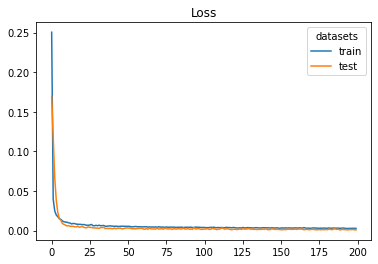

In [15]:
# define encoder
visible = Input(shape=(n_inputs,))

# encoder level 1
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 2
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# encoder level 3
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# bottleneck
n_bottleneck = 50
bottleneck = Dense(n_bottleneck)(e)


# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# decoder level 2
d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)

# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=200, batch_size=16, verbose=2, validation_data=(X_test,X_test))

# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend(title = "datasets")
pyplot.title("Loss")
pyplot.show()

Είναι φανερό ότι το validation loss δε μεταβλήθηκε σημαντικά από την προσθήκη του 3ου επιπέδου και για τιμή bottleneck = 50 καθώς παραμένει της τάξης του $10^{-3}$. Επομένως, αν είχαμε να επιλέξουμε μεταξύ μοντέλων, θα διαλέγαμε το απλούστερο εκ των δύο, ήτοι εκείνο με τα 2 επίπεδα συν το bottleneck.